In [1]:
# Using SWAN release 99
# pip install --user particle

In [68]:
import sys
import uproot
import uproot_methods
import numpy as np
import matplotlib.pyplot as plt 
import awkward
import pickle
import os
from tqdm.notebook import tqdm
from os.path import splitext,exists
from particle import Particle
from itertools import chain

In [2]:
def addPileup(events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double,no_empty=False):
    # in case of no_empty, reset the xi jagged arrays 
    n_events=len(events["Electron_size"])        
    if no_empty:
        events["xi_pos"] = []
        events["xi_neg"] = []
    for i in range(n_events):
        events["xi_pos"].append([])
        events["xi_neg"].append([])
        puEvents = np.random.poisson(pileup)
        first_round = True
        while (( ((len(events["xi_pos"][i]) < 1) | (len(events["xi_neg"][i]) < 1)) & no_empty) | ((not no_empty) & first_round)):
            for j in range(puEvents):
                tag_rng = np.random.uniform()
                if tag_rng <= p_double:
                    events["xi_pos"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                    events["xi_neg"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                elif (tag_rng > p_double) & (tag_rng <= p_double+p_single):
                    events["xi_pos"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.
                elif (tag_rng > p_double+p_single) & (tag_rng <= p_double+2*p_single):
                    events["xi_neg"][i].append(xi_min *np.power( xi_max/xi_min, np.random.uniform())*np.random.normal(1,proton_xi_res)) # Assign a proton with xi1 sample from dsigma/dxi ~ 1/xi, smeared.        
            first_round = False
    if no_empty:
        events["xi_pos"] = awkward.JaggedArray.fromiter(events["xi_pos"])
        events["xi_neg"] = awkward.JaggedArray.fromiter(events["xi_neg"])
        events["xi_pos_size"] = np.array([len(i) for i in events["xi_pos"]])
        events["xi_neg_size"] = np.array([len(i) for i in events["xi_neg"]])

In [3]:
pileup = 50 
proton_xi_res = 0.02 # proton resolution
xi_min = 0.015 # min xi acceptance for pileup
xi_max = 0.15  # max xi acceptance for pileup
p_double = 8.8E-5 # probability of having a double tag pileup event (central-diffractive or single-diffractive x2)
p_single = 0.015 # probability of having a single tag pileup event (single-diffractive x2)

# Prepare dataset as signal or background
def prepDelphesDataset(isSignal=True, isTtbar=False, filename="", addPU = True):
    computeDecayType=False
    print("Loading file:",filename)
    file = uproot.open(filename)
    tree = file["Delphes"]
    # Pick only the needed branches
    branchSelection = [
        "Particle.PID","Particle.Status","Particle.M1","Particle.Px","Particle.Py","Particle.Pz","Particle.E",
        "Electron_size","Muon_size","MissingET.MET","Electron.PT","Muon.PT","Electron.Eta","Electron.Phi","Muon.Eta",
        "Muon.Phi","MissingET.Phi","Jet.BTag","Jet.PT","Jet.Eta","Jet.Phi","Jet.Mass"
                      ]
    events = tree.arrays(branchSelection,namedecode="utf-8")
    events["BJets_size"] = np.array([np.sum(i) for i in (events["Jet.BTag"] == True)])
    events["NonBJets_size"] = np.array([np.sum(i) for i in (events["Jet.BTag"] == False)])
    
    n_events=len(events["Particle.PID"]) # n_events (updated along the way)
    initial_n_events=len(events["Particle.PID"]) # initial n_events
    print("Analyzing ",initial_n_events,"events...")
    
    if isTtbar | isSignal:
            print("Preparing ttbar variables...")
            # Select the gen level tops
            gen_top1_sel = (events["Particle.PID"] == 6) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))
            gen_top2_sel = (events["Particle.PID"] == -6 ) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))

            before_n = len(events["Particle.PID"])
            # Remove events with more than one gen ttbar (apparently it can happen)
            good_genTops = [len(i) == 1 and len(j) == 1 for i,j in zip(events["Particle.Px"][gen_top1_sel],events["Particle.Px"][gen_top2_sel])]
            for key in events:
                    events[key] = events[key][good_genTops]
            n_events=len(events["Particle.PID"])
            after_n = len(events["Particle.PID"])
            print("Removed {}% of the events because of weird gen ttbar system".format(100*(before_n-after_n)/initial_n_events))

            gen_top1_sel = (events["Particle.PID"] == 6) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))
            gen_top2_sel = (events["Particle.PID"] == -6 ) & ((events["Particle.Status"] == 123) | (events["Particle.Status"] == 124) | (events["Particle.Status"] == 22))

            events["gen_top1"] = uproot_methods.TLorentzVectorArray.from_cartesian(events["Particle.Px"][gen_top1_sel],events["Particle.Py"][gen_top1_sel],events["Particle.Pz"][gen_top1_sel],events["Particle.E"][gen_top1_sel]).flatten()
            events["gen_top2"] = uproot_methods.TLorentzVectorArray.from_cartesian(events["Particle.Px"][gen_top2_sel],events["Particle.Py"][gen_top2_sel],events["Particle.Pz"][gen_top2_sel],events["Particle.E"][gen_top2_sel]).flatten()
            events["gen_m_ttbar"] = (events["gen_top1"]+events["gen_top2"]).mass
            print("Done.")
            if computeDecayType:
                decayFilename = splitext(filename)[0]+"_decayChannel.npy"
                if exists(decayFilename):
                    print("Loading decay channels from",decayFilename)
                    events["decay_channel"] = np.load(decayFilename,allow_pickle='TRUE')
                    print("Done.")
                else:
                    print("Computing ttbar decay type... this will take a while")
                    # Machinery to reconstruct the decay type
                    top_decay = []
                    for event_n in range(n_events):
                        top_decay.append([0,0])
                        mask = []
                        for mom_n in (events["Particle.M1"])[event_n]:
                            if mom_n >= 0:
                                mask.append(events["Particle.PID"][event_n][mom_n] == 24) 
                            else:
                                mask.append(True)

                        requirement = (mask & (events["Particle.PID"] != 24)[event_n] & (events["Particle.M1"] > 0)[event_n])
                        for top_decay_PID in events["Particle.PID"][event_n][requirement]:
                            if top_decay_PID != 22:
                                if top_decay_PID > 0:
                                    top_decay[event_n][0] += top_decay_PID * 100
                                else:
                                    top_decay[event_n][0] += -top_decay_PID
                    print("I'm halfway through")
                    for event_n in range(n_events):
                        mask = []
                        for mom_n in (events["Particle.M1"])[event_n]:
                            if mom_n >= 0:
                                mask.append(events["Particle.PID"][event_n][mom_n] == -24) 
                            else:
                                mask.append(True)

                        requirement = (mask & (events["Particle.PID"] != -24)[event_n] & (events["Particle.M1"] > 0)[event_n])
                        for top_decay_PID in events["Particle.PID"][event_n][requirement]:
                            if top_decay_PID != 22:
                                if top_decay_PID > 0:
                                    top_decay[event_n][1] += top_decay_PID * 100
                                else:
                                    top_decay[event_n][1] += -top_decay_PID
                    # Print decay fractions
                    n_lep = 0
                    n_semilep = 0
                    n_had = 0
                    decay_channel=[]
                    for event_n in range(n_events):
                        if top_decay[event_n][0] > 1000 and top_decay[event_n][1] > 1000:
                            decay_channel.append("lep")
                        elif top_decay[event_n][0] > 1000 or top_decay[event_n][1] > 1000:
                            decay_channel.append("semilep")
                        else:
                            decay_channel.append("had")
                    events["decay_channel"] = np.array(decay_channel)
                    print("Done.")
                    np.save(decayFilename, events["decay_channel"])
                    print("Saved decay channel in",decayFilename)
                n_lep = np.count_nonzero(events["decay_channel"] == "lep")
                n_semilep = np.count_nonzero(events["decay_channel"] == "semilep")
                n_had = np.count_nonzero(events["decay_channel"] == "had") 
                print("\tFully leptonic fraction:",n_lep*100/n_events,"%")
                print("\tSemileptonic fraction:",n_semilep*100/n_events,"%")
                print("\tHadronic fraction:",n_had*100/n_events,"%")
            
    if isSignal:
        print("Creating gen variables...")
        # Reconstruct the gen level xi
        gen_P_pos_sel = (events["Particle.PID"] == 2212) & (events["Particle.Pz"] > 3000) & (events["Particle.Status"] == 1)
        events["gen_xi_pos"] = 1 - events["Particle.E"][gen_P_pos_sel]/7000.
        gen_P_neg_sel = (events["Particle.PID"] == 2212) & (events["Particle.Pz"] < -3000) & (events["Particle.Status"] == 1)
        events["gen_xi_neg"] = 1 - np.abs(events["Particle.E"][gen_P_neg_sel]/7000.)

        # Find events with out-of-range xi values and remove them
        counter = 0
        not_weird_xi = []
        for i in range(len(events["Particle.Pz"][gen_P_pos_sel])):
            if len(events["gen_xi_pos"][i]) > 0 and len(events["gen_xi_neg"][i]) > 0:
                if events["gen_xi_pos"][i] > 0.2 or events["gen_xi_pos"][i] < 0.015 or events["gen_xi_neg"][i] > 0.2 or events["gen_xi_neg"][i] < 0.015:
                    counter += 1
                    not_weird_xi.append(False)
                else:
                    not_weird_xi.append(True)
            else:
                counter += 1
                not_weird_xi.append(False)
        print("Found {:.1f}% weird xi events".format(counter/n_events*100))
        for key in events:
                events[key] = events[key][not_weird_xi]
        n_events=len(events["Particle.PID"])
        events["gen_xi_pos"] = np.array(events["gen_xi_pos"].flatten())
        events["gen_xi_neg"] = np.array(events["gen_xi_neg"].flatten())
        # Compute the central mass and rapidity from the gen protons
        events["gen_m_protons"] = 14000 * np.sqrt(events["gen_xi_pos"] * events["gen_xi_neg"])
        events["gen_y_protons"] = 0.5 * np.log(events["gen_xi_pos"] / events["gen_xi_neg"])
        # Compute xi with smearing
        events["xi_pos"] = []
        events["xi_neg"] = []
        print("Done.")
        print("Smearing gen protons...")
        for i in range(n_events):
            events["xi_pos"].append([events["gen_xi_pos"][i] * np.random.normal(1,proton_xi_res)])
            events["xi_neg"].append([events["gen_xi_neg"][i] * np.random.normal(1,proton_xi_res)])
        print("Done.")
    else:
        events["xi_pos"] = []
        events["xi_neg"] = []
    if addPU:
        print("Adding pileup protons...")
        addPileup(events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double)        
        print("Done.")    
    events["xi_pos"] = awkward.JaggedArray.fromiter(events["xi_pos"])
    events["xi_neg"] = awkward.JaggedArray.fromiter(events["xi_neg"])
    events["xi_pos_size"] = np.array([len(i) for i in events["xi_pos"]])
    events["xi_neg_size"] = np.array([len(i) for i in events["xi_neg"]])
    
    usefulVars = ["xi_pos_size","xi_neg_size","xi_pos","xi_neg","decay_channel",
                  "gen_m_ttbar","gen_m_protons","gen_top1","Electron_size","Muon_size","BJets_size",
                  "NonBJets_size","MissingET.MET","Electron.PT","Muon.PT","Electron.Eta","Electron.Phi",
                  "Muon.Eta","Muon.Phi","MissingET.Phi","Jet.BTag","Jet.PT","Jet.Eta","Jet.Phi","Jet.Mass"
                 ]
    for key in list(events):
        if key not in usefulVars:
            del events[key]
    print("Finished!\n")
    return events

In [4]:
def plotWithRange(variable,nbins,xmin,xmax,xlabel="",histlabel="",axis=None,scalefactor=1,logscale=False,normalize=False):
    binWidth=(float)(xmax-xmin)/nbins
    ax = axis
    if axis==None:
        fig,ax = plt.subplots(1,figsize=(15,10))
    if normalize:
        scalefactor = 1. / len(variable)
    binEdges=[xmin+i*binWidth for i in range(nbins+1)]
    y, bin_edges,patches = ax.hist(variable, bins=binEdges,histtype="step",label=histlabel,weights = np.ones_like(variable) * scalefactor)
    plt.xlabel(xlabel,fontsize=20)
    plt.xlim([xmin,xmax])
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(
        bin_centers,
        y,
        yerr = (y*scalefactor)**0.5,
        marker = '.',
        linestyle = 'None',
        drawstyle = 'steps-mid',
        color=patches[0].get_edgecolor()
    )
    if logscale:
        plt.yscale("log")
    if histlabel != "":
        plt.legend(fontsize=20)
    return ax

In [5]:
def scanCut(signal_ds,background_ds,f_cut,par_start_stop_step,x_label=""):
    n_signal = len(signal_ds[list(signal_ds.keys())[0]])
    n_background = len(background_ds[list(background_ds.keys())[0]])
    cut_values = []
    signal_fractions = []
    background_fractions = []
    signal_over_sqrtb = []
    for par in np.arange(par_start_stop_step[0],par_start_stop_step[1]+par_start_stop_step[2],par_start_stop_step[2]):
        cut_values.append(par)
        sig_pass = sum(f_cut(signal_ds,par))
        bg_pass = sum(f_cut(background_ds,par))
        signal_fractions.append(sig_pass/n_signal)
        background_fractions.append(bg_pass/n_background)
        if bg_pass == 0:
            print("No BG events passed for par = ",par,"\nUsing 0.0001 as symbolic value")
            bg_pass = 0.0001
        signal_over_sqrtb.append(sig_pass/np.sqrt(bg_pass))
    fig,ax = plt.subplots(1,figsize=(15,10))
    aux_arr = np.abs(0.9-np.array(signal_fractions))
    sig_eff_90 = min(aux_arr)
    sig_eff_90_index = list(aux_arr).index(sig_eff_90)
    max_sbr = max(signal_over_sqrtb)
    max_index = signal_over_sqrtb.index(max_sbr)
    print("Maximum signal over square root of background:", max_sbr, "for cut value:",cut_values[max_index],"(sig. eff.:",100.*signal_fractions[max_index],"%, bg. rej.",100.*(1-background_fractions[max_index]),"%)")
    print("Closest point to 90% signal efficiency at cut value:",cut_values[sig_eff_90_index],"(sig. eff.:",100.*signal_fractions[sig_eff_90_index],"%, bg. rej.",100.*(1-background_fractions[sig_eff_90_index]),"%)")
    ax.plot(cut_values,signal_fractions, label="Signal efficiency")
    ax.plot(cut_values,1 - np.array(background_fractions), label="Background rejection")
    ax.plot(cut_values,np.array(signal_over_sqrtb)/max_sbr, label=r"$(S/\sqrt{B})/(S/\sqrt{B})_{max}$")  
    plt.xlabel(x_label,fontsize=20)
    plt.legend(fontsize=20)

In [6]:
# sample names
exampleSignal_1E12 = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/105/excl_anomTtbar_QED.root"
exampleSignal_1E11 = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/104/excl_anomTtbar_QED.root"
SM_ttbar = "/eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_ttbar/Events/run_10/tag_1_delphes_events.root"

# prepare fractions
frac_passing_semilep_presel_signal_1E12 = 1
frac_passing_semilep_presel_signal_1E11 = 1
protons_in_pps_weight = 0.27832
frac_passing_semilep_presel_SM_ttbar = 1

frac_passing_semilep_centralsel_signal_1E12 = 1
frac_passing_semilep_centralsel_signal_1E11 = 1
frac_passing_semilep_centralsel_SM_ttbar = 1

frac_passing_semilep_fullsel_signal_1E12 = 1
frac_passing_semilep_fullsel_signal_1E11 = 1
frac_passing_fullep_centralsel_SM_ttbar = 1

# prepare datasets
exampleSignal_1E12_ds = prepDelphesDataset(True,True,exampleSignal_1E12,addPU=False)
exampleSignal_1E11_ds = prepDelphesDataset(True,True,exampleSignal_1E11,addPU=False)
SM_ttbar_ds = prepDelphesDataset(False,True,SM_ttbar)

Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/105/excl_anomTtbar_QED.root
Analyzing  10000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Creating gen variables...
Found 1.7% weird xi events
Done.
Smearing gen protons...
Done.
Finished!

Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/104/excl_anomTtbar_QED.root
Analyzing  10000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Creating gen variables...
Found 1.7% weird xi events
Done.
Smearing gen protons...
Done.
Finished!

Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/MadGraph/MG5_aMC_v3_1_0/SM_ttbar/Events/run_10/tag_1_delphes_events.root
Analyzing  50000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Adding pileup protons...
Done.
Finished!



In [77]:
signalPathTemplate = "/eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/{}/excl_anomTtbar_QED.root"

def prepareSamples(isSignal=True,isTtbar=False,addPU = True,filenameTemplate="",sampleIDs=[]):
    for sampleID in tqdm(sampleIDs):
        sampleName = filenameTemplate.format(sampleID)
        events = prepDelphesDataset(isSignal,isTtbar,sampleName,addPU)
        if (not isSignal) and addPU:
            addPileup(events,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double,True)        
        with open(sampleName.replace('.root','_skim.pickle'),'wb') as handle:
            pickle.dump(events,handle,protocol=pickle.HIGHEST_PROTOCOL)
        
def runSelection(select,filenameTemplate="",sampleIDs=[],suffix=""):
    for sampleID in tqdm(sampleIDs):
        sampleName = filenameTemplate.format(sampleID)
        with open(sampleName,'rb') as handle:
            events = pickle.load(handle)
        events = select(events)   
        with open(sampleName.replace('.pickle',suffix+'.pickle'),'wb') as handle:
            pickle.dump(events,handle,protocol=pickle.HIGHEST_PROTOCOL)

def loadEvents(filenameTemplate="",sampleIDs=[]):
    events = {}
    for sampleID in tqdm(sampleIDs):
        sampleName = filenameTemplate.format(sampleID)
        with open(sampleName,'rb') as handle:
            for k,v in pickle.load(handle).items():
                if k in events.keys():
                    if type(v) is np.ndarray:
                        events[k] = np.append(events[k],v)
                    elif type(v) is awkward.JaggedArray:
                        events[k] = events[k].concatenate([v])
                    elif type(v) is uproot_methods.TLorentzVectorArray:
                        events[k] = [v for v in chain(events[k],v)]
                    else:
                        events[k].append(v)
                else:
                    events[k] = v
    return events

In [78]:
signal_Xi1_1E12 = ["105","106","107"]
prepareSamples(True,True,False,signalPathTemplate,signal_Xi1_1E12)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/105/excl_anomTtbar_QED.root
Analyzing  10000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Creating gen variables...
Found 1.7% weird xi events
Done.
Smearing gen protons...
Done.
Finished!

Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/106/excl_anomTtbar_QED.root
Analyzing  10000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Creating gen variables...
Found 1.7% weird xi events
Done.
Smearing gen protons...
Done.
Finished!

Loading file: /eos/home-a/abellora/SWAN_projects/TopPheno/FPMC_tools/DELPHES/107/excl_anomTtbar_QED.root
Analyzing  10000 events...
Preparing ttbar variables...
Removed 0.0% of the events because of weird gen ttbar system
Done.
Creating gen variables...
Found 1.7% weird xi events
Done.
Smearing gen protons...
Done.
Finished!



In [79]:
test = loadEvents(signalPathTemplate.replace('.root','_skim.pickle'),sampleIDs=signal_Xi1_1E12)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# produce weight for number of events having at least one proton per arm in the final state in BG
n_events = len(SM_ttbar_ds["xi_pos_size"])
n_mthan1ProtPerSide = np.sum((SM_ttbar_ds["xi_pos_size"] >= 1) & (SM_ttbar_ds["xi_neg_size"] >= 1))
protons_in_pps_weight = n_mthan1ProtPerSide / n_events
print("Weight factor =",protons_in_pps_weight)

Weight factor = 0.27832


In [12]:
# Force pileup into each BG event (not to waste good MC)
addPileup(SM_ttbar_ds,pileup,proton_xi_res,xi_min,xi_max,p_single,p_double,True)        

In [10]:
# total integrated luminosity for the study
lumi_tot = 300. # 1/fb

# cross sections
exampleSignal_1E12_xsec = 9.4752087813178445E-005 * 1e+3 #fb
exampleSignal_1E11_xsec = 9.4752087813173274E-003 * 1e+3 #fb
SM_ttbar_xsec = 832 * 1e+3 #fb

# scale factors for histograms in absolute values
exampleSignal_1E12_sf = lumi_tot * exampleSignal_1E12_xsec / len(exampleSignal_1E12_ds["xi_pos_size"])
exampleSignal_1E11_sf = lumi_tot * exampleSignal_1E11_xsec / len(exampleSignal_1E11_ds["xi_pos_size"])
SM_ttbar_sf = protons_in_pps_weight * lumi_tot * SM_ttbar_xsec / len(SM_ttbar_ds["xi_pos_size"])

# scale factors for histograms in normalization to 1
exampleSignal_1E12_sf_norm1 = 1. / len(exampleSignal_1E12_ds["xi_pos_size"])
exampleSignal_1E11_sf_norm1 = 1. / len(exampleSignal_1E11_ds["xi_pos_size"])
SM_ttbar_sf_norm1 = 1. / len(SM_ttbar_ds["xi_pos_size"])

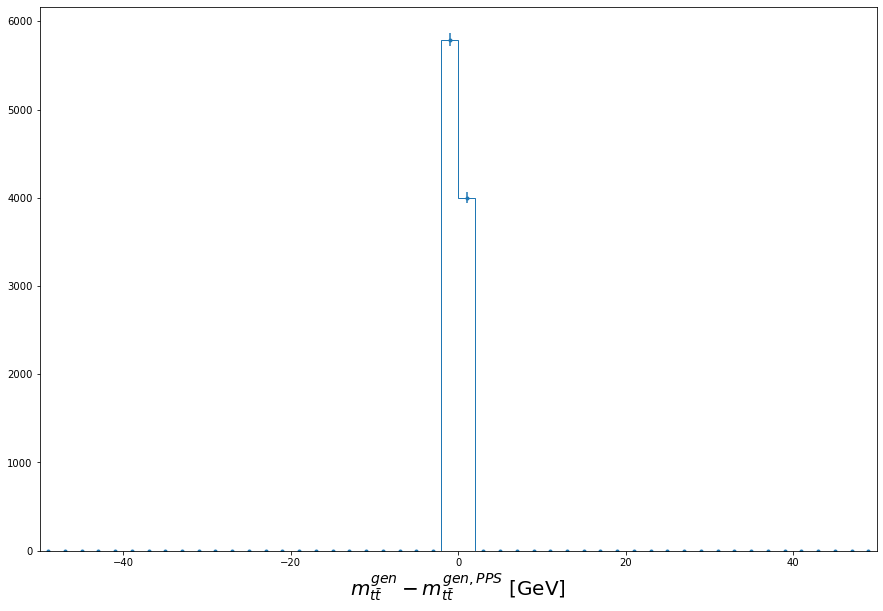

In [10]:
ax = plotWithRange(exampleSignal_1E12_ds["gen_m_ttbar"]-exampleSignal_1E12_ds["gen_m_protons"],50,-50,50,r"$m_{t\bar{t}}^{gen} - m_{t\bar{t}}^{gen,PPS}$ [GeV]")

<AxesSubplot:xlabel='$m_{t\\bar{t}}^{gen}$ [GeV]'>

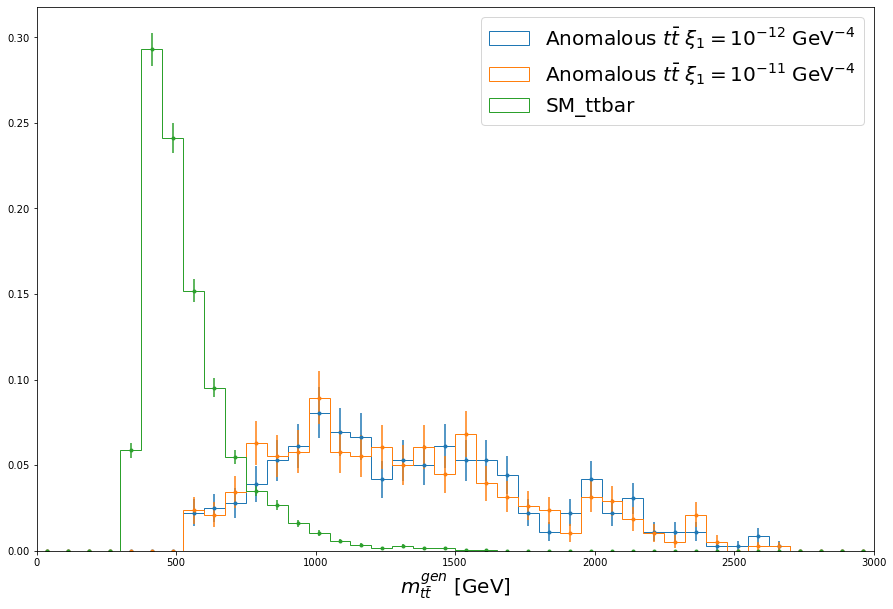

In [19]:
ax = plotWithRange(exampleSignal_1E12_ds["gen_m_ttbar"],40,0,3000,r"$m_{t\bar{t}}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange(exampleSignal_1E11_ds["gen_m_ttbar"],40,0,3000,r"$m_{t\bar{t}}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(SM_ttbar_ds["gen_m_ttbar"],40,0,3000,r"$m_{t\bar{t}}^{gen}$ [GeV]","SM_ttbar",ax,normalize=True)

<AxesSubplot:xlabel='$p_{T}^{top,gen}$ [GeV]'>

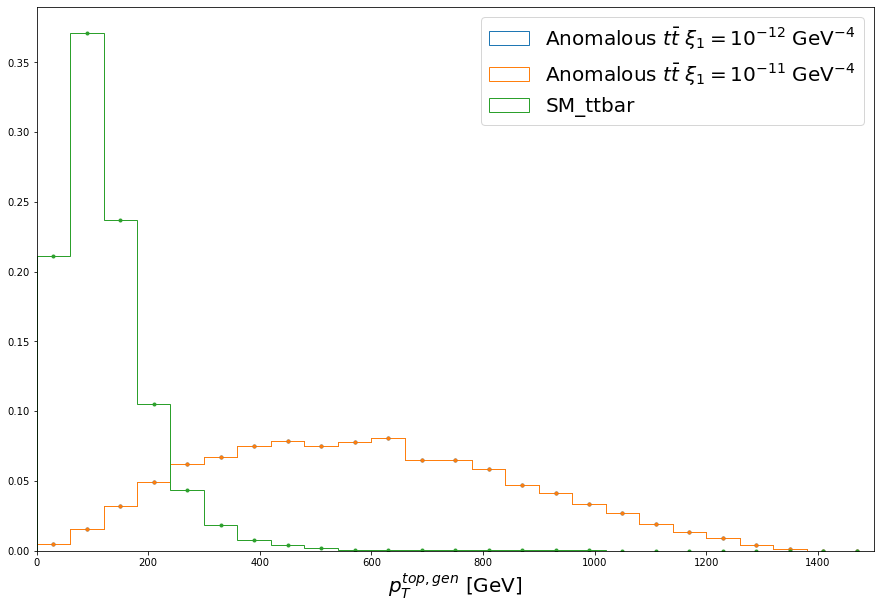

In [12]:
ax = plotWithRange([ t.pt for t in exampleSignal_1E12_ds["gen_top1"]],25,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange([ t.pt for t in exampleSignal_1E11_ds["gen_top1"]],25,0,1500,r"$p_{T}^{top}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ t.pt for t in SM_ttbar_ds["gen_top1"]],25,0,1500,r"$p_{T}^{top,gen}$ [GeV]","SM_ttbar",ax,normalize=True)

In [11]:
# compute the pz of the neutrino imposing the neutrino+lepton system to have the mass of the W

def addPzToNeutrino(neutrino,lepton):
    a = ((lepton.mass**2 - (Particle.from_pdgid(24).mass*1E-3)**2)/2 - lepton.p3.x * neutrino.p3.x - lepton.p3.y * neutrino.p3.y )/lepton.energy
    b = lepton.p3.z / lepton.energy
    sqrt_delta4 = np.sqrt(np.complex(a**2 + (b**2)*(neutrino.pt**2) - neutrino.pt**2))
    nu_pz_1 = (a*b + sqrt_delta4.real )/(b**2 - 1)
    nu_pz_2 = (a*b - sqrt_delta4.real )/(b**2 - 1)
    if np.abs(nu_pz_1 - lepton.p3.z) < np.abs(nu_pz_2 - lepton.p3.z):
        neutrino = uproot_methods.TLorentzVector.from_xyzm(neutrino.p3.x,neutrino.p3.y,nu_pz_1,0)
    else:
        neutrino = uproot_methods.TLorentzVector.from_xyzm(neutrino.p3.x,neutrino.p3.y,nu_pz_2,0)
    return neutrino

In [12]:
# Analyze semileptonic channel
def semilepAnalysisPreselection(dataset):
    ## Preselection
    mthan1Lep_sel = (dataset["Electron_size"] > 0) | (dataset["Muon_size"] > 0)
    mthan2BJets_sel = dataset["BJets_size"] >= 2
    mthan2NonBJets_sel = dataset["NonBJets_size"] >= 2
    mthan20gevMET_sel = (dataset["MissingET.MET"] > 20).flatten()
    mthan1ProtPerSide_sel = (dataset["xi_pos_size"] >= 1) & (dataset["xi_neg_size"] >= 1)
    semilep_presel = mthan1Lep_sel & mthan2BJets_sel & mthan2NonBJets_sel & mthan20gevMET_sel & mthan1ProtPerSide_sel

    frac_passing = 1.*np.count_nonzero(semilep_presel)/len(dataset["xi_neg_size"])
    print("Passing semilep preselection:", np.count_nonzero(semilep_presel),"({:.2f}%)".format(100.*frac_passing))
    for key in dataset:
        dataset[key] = dataset[key][semilep_presel]

    # Reconstruct ttbar system

    dataset["Lepton"] = np.array([])
    dataset["Neutrino"] = np.array([])
    dataset["BJet_1"] = np.array([])
    dataset["BJet_2"] = np.array([])
    dataset["Jet_1"] = np.array([])
    dataset["Jet_2"] = np.array([])
    dataset["top_1"] = np.array([])
    dataset["top_2"] = np.array([])
    for i in range(len(dataset["Electron_size"])):
        
        # Choose the highest PT lepton
        max_pt_e = 0
        max_pt_e_idx = -1
        max_pt_mu = 0
        max_pt_mu_idx = -1
        if dataset["Electron_size"][i] > 0:
            max_pt_e = dataset["Electron.PT"][i][0]
        if dataset["Muon_size"][i] > 0:
            max_pt_mu = dataset["Muon.PT"][i][0]
        if max_pt_e > max_pt_mu:
            lepton = uproot_methods.TLorentzVector.from_ptetaphim(max_pt_e,dataset["Electron.Eta"][i][0],dataset["Electron.Phi"][i][0],Particle.from_pdgid(11).mass*1E-3)
        else:
            lepton = uproot_methods.TLorentzVector.from_ptetaphim(max_pt_mu,dataset["Muon.Eta"][i][0],dataset["Muon.Phi"][i][0],Particle.from_pdgid(13).mass*1E-3)
        dataset["Lepton"] = np.append(dataset["Lepton"],lepton)
        # Add the neutrino (pz obtained imposing (neutrino+lepton).mass = W.mass)
        neutrino = uproot_methods.TLorentzVector.from_ptetaphim(dataset["MissingET.MET"][i][0],0,dataset["MissingET.Phi"][i][0],0)
        neutrino = addPzToNeutrino(neutrino,lepton)
        dataset["Neutrino"] = np.append(dataset["Neutrino"],neutrino)
        # Get the two most energetic BJets
        bjets_sel = dataset["Jet.BTag"] == True
        bjet_1 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][bjets_sel][i][0],dataset["Jet.Eta"][bjets_sel][i][0],dataset["Jet.Phi"][bjets_sel][i][0],dataset["Jet.Mass"][bjets_sel][i][0])
        bjet_2 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][bjets_sel][i][1],dataset["Jet.Eta"][bjets_sel][i][1],dataset["Jet.Phi"][bjets_sel][i][1],dataset["Jet.Mass"][bjets_sel][i][1])
        dataset["BJet_1"] = np.append(dataset["BJet_1"],bjet_1)
        dataset["BJet_2"] = np.append(dataset["BJet_2"],bjet_2)
        # Get the two most energetic NonBJets
        jets_sel = dataset["Jet.BTag"] == False
        jet_1 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][jets_sel][i][0],dataset["Jet.Eta"][jets_sel][i][0],dataset["Jet.Phi"][jets_sel][i][0],dataset["Jet.Mass"][jets_sel][i][0])
        jet_2 = uproot_methods.TLorentzVector.from_ptetaphim(dataset["Jet.PT"][jets_sel][i][1],dataset["Jet.Eta"][jets_sel][i][1],dataset["Jet.Phi"][jets_sel][i][1],dataset["Jet.Mass"][jets_sel][i][1])
        dataset["Jet_1"] = np.append(dataset["Jet_1"],jet_1)
        dataset["Jet_2"] = np.append(dataset["Jet_2"],jet_2)
        # Reconstruct the two tops (top_1 is semi-lep, top_2 is hadronic)
        # Assign b-jets based on the mass of the dijet+bjet system being close to the top mass
        if np.abs((jet_1 + jet_2 + bjet_1).mass - Particle.from_pdgid(6).mass*1E-3) < ((jet_1 + jet_2 + bjet_2).mass - Particle.from_pdgid(6).mass*1E-3):
            top_1 = neutrino + lepton + bjet_2
            top_2 = jet_1 + jet_2 + bjet_1
        else:
            top_1 = neutrino + lepton + bjet_1
            top_2 = jet_1 + jet_2 + bjet_2
        dataset["top_1"] = np.append(dataset["top_1"],top_1)
        dataset["top_2"] = np.append(dataset["top_2"],top_2)     
        
    dataset["m_ttbar"] = np.array([ttbar.mass for ttbar in dataset["Lepton"] + dataset["Neutrino"] + dataset["BJet_1"] + dataset["BJet_2"] + dataset["Jet_1"] + dataset["Jet_2"]])
    dataset["y_ttbar"] = np.array([ttbar.rapidity for ttbar in dataset["Lepton"] + dataset["Neutrino"] + dataset["BJet_1"] + dataset["BJet_2"] + dataset["Jet_1"] + dataset["Jet_2"]])
    
    # Compute mass from protons
    dataset["m_protons"] = np.array([14000 * np.sqrt(max(xi_pos) * max(xi_neg)) for xi_pos,xi_neg in zip(dataset["xi_pos"],dataset["xi_neg"])])
    # Compute rapidity from protons
    dataset["y_protons"] = np.array([0.5 * np.log(max(xi_pos) / max(xi_neg)) for xi_pos,xi_neg in zip(dataset["xi_pos"],dataset["xi_neg"])])
    
    # Compute the sum of the BJet energies
    dataset["BJet_energy_tot"] = np.array([j1.energy+j2.energy for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    # Compute the sum of the BJet PT
    dataset["BJet_pt_tot"] = np.array([j1.pt+j2.pt for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    # Compute the sum of the BJet acoplanarity
    dataset["BJet_acoplanarity"] = np.array([np.abs(1-(j1.phi-j2.phi)/np.pi) for j1,j2 in zip(dataset["BJet_1"],dataset["BJet_2"])])
    
    # Compute the sum of the non-BJet energies
    dataset["Jet_energy_tot"] = np.array([j1.energy+j2.energy for j1,j2 in zip(dataset["Jet_1"],dataset["Jet_2"])])
    # Compute the sum of the non-BJet PT
    dataset["Jet_pt_tot"] = np.array([j1.pt+j2.pt for j1,j2 in zip(dataset["Jet_1"],dataset["Jet_2"])])
    
    usefulVars = [
        "Neutrino","top_1","top_2","m_ttbar","y_ttbar","gen_m_ttbar",
        "Jet_pt_tot","BJet_pt_tot","m_protons","y_protons"
    ]
    for key in list(events):
        if key not in usefulVars:
            del events[key]
            
    return dataset,frac_passing

In [15]:
# perform preselection
exampleSignal_1E12_semilep_presel_ds,frac_passing_semilep_presel_signal_1E12 = semilepAnalysisPreselection(exampleSignal_1E12_ds)
exampleSignal_1E11_semilep_presel_ds,frac_passing_semilep_presel_signal_1E11 = semilepAnalysisPreselection(exampleSignal_1E11_ds)
SM_ttbar_semilep_presel_ds,frac_passing_semilep_presel_SM_ttbar = semilepAnalysisPreselection(SM_ttbar_ds)

Passing semilep preselection: 360 (3.66%)
Passing semilep preselection: 380 (3.87%)
Passing semilep preselection: 3204 (6.41%)


In [13]:
# perform preselection
exampleSignal_1E12_ds,frac_passing_semilep_presel_signal_1E12 = semilepAnalysisPreselection(exampleSignal_1E12_ds)
exampleSignal_1E11_ds,frac_passing_semilep_presel_signal_1E11 = semilepAnalysisPreselection(exampleSignal_1E11_ds)
SM_ttbar_ds,frac_passing_semilep_presel_SM_ttbar = semilepAnalysisPreselection(SM_ttbar_ds)

Passing semilep preselection: 360 (3.66%)
Passing semilep preselection: 380 (3.87%)
Passing semilep preselection: 3204 (6.41%)


In [ ]:
usefulVars = ["Neutrino","top_1","top_2","m_ttbar","y_ttbar","gen_m_ttbar","Jet_pt_tot","BJet_pt_tot","m_protons","y_protons"]
for key in list(exampleSignal_1E12_ds):
    if key not in usefulVars:
        del exampleSignal_1E12_ds[key]

<AxesSubplot:xlabel='$p_z^{\\nu}$ [GeV]'>

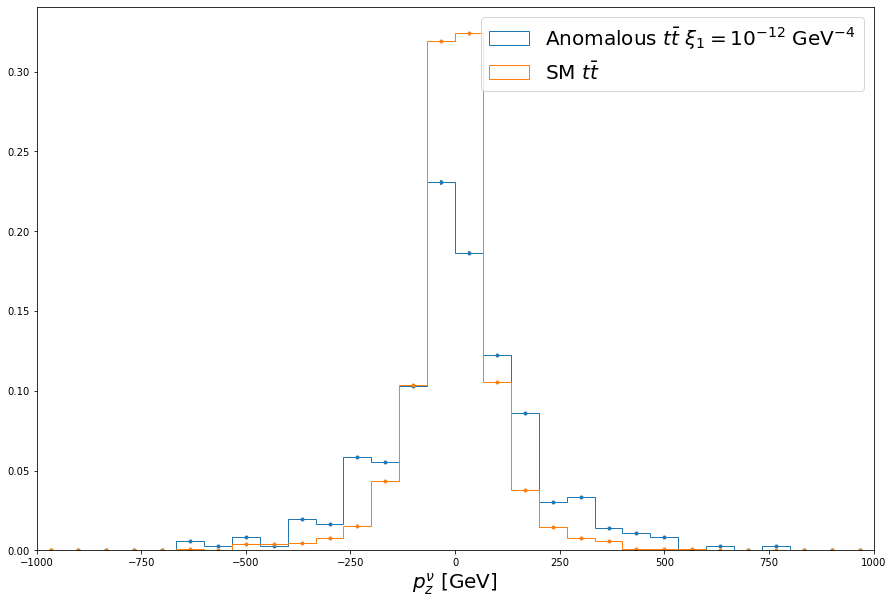

In [16]:
ax = plotWithRange([n.p3.z for n in exampleSignal_1E12_semilep_presel_ds["Neutrino"]],30,-1000,1000,r"$p_z^{\nu}$ [GeV]",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange([n.p3.z for n in SM_ttbar_semilep_presel_ds["Neutrino"]],30,-1000,1000,r"$p_z^{\nu}$ [GeV]",r"SM $t\bar{t}$",ax,normalize=True)

<AxesSubplot:xlabel='$|1-\\frac{|\\phi^{t_1}-\\phi^{t_2}|}{\\pi}|$'>

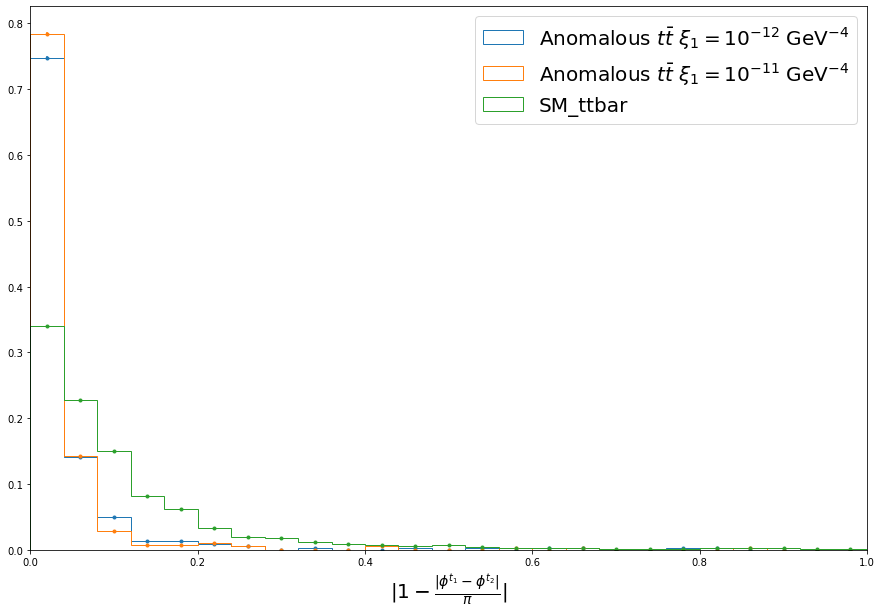

In [17]:
ax = plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(exampleSignal_1E12_semilep_presel_ds["top_1"],exampleSignal_1E12_semilep_presel_ds["top_2"])],25,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(exampleSignal_1E11_semilep_presel_ds["top_1"],exampleSignal_1E11_semilep_presel_ds["top_2"])],25,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) for t1,t2 in zip(SM_ttbar_semilep_presel_ds["top_1"],SM_ttbar_semilep_presel_ds["top_2"])],25,0,1,r"$|1-\frac{|\phi^{t_1}-\phi^{t_2}|}{\pi}|$","SM_ttbar",ax,normalize=True)

No BG events passed for par =  0.0 
Using 0.0001 as symbolic value
Maximum signal over square root of background: 8.874887963441362 for cut value: 0.005 (sig. eff.: 31.666666666666664 %, bg. rej. 94.85018726591761 %)
Closest point to 90% signal efficiency at cut value: 0.09 (sig. eff.: 90.27777777777779 %, bg. rej. 39.48189762796505 %)


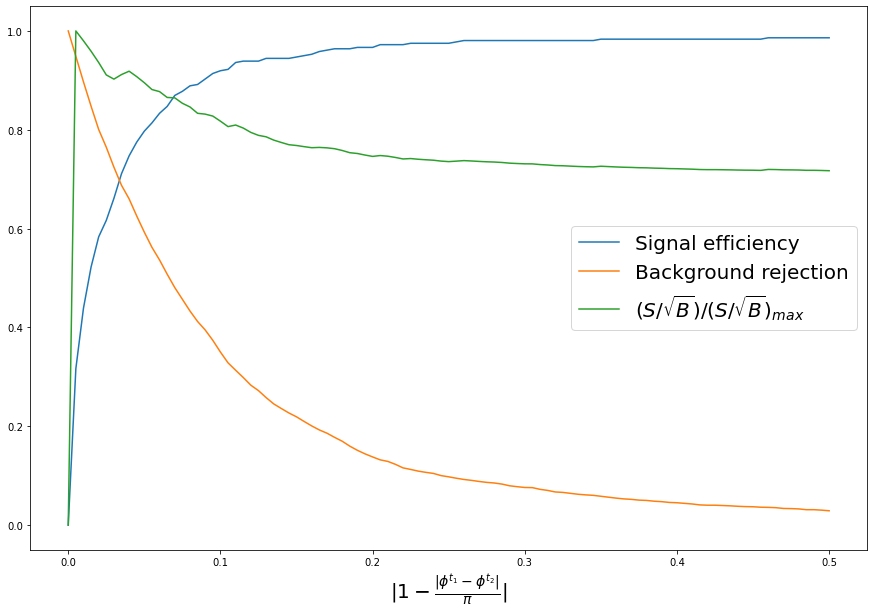

In [18]:
def acoplanarity_lowerThan(ds,par):
    return [np.abs(1-np.abs(t1.phi-t2.phi)/np.pi) < par for t1,t2 in zip(ds["top_1"],ds["top_2"])]

scanCut(exampleSignal_1E12_semilep_presel_ds,SM_ttbar_semilep_presel_ds,acoplanarity_lowerThan,[0,0.5,0.5/100],r"$|1-\frac{|\phi^{t_1}-\phi^{t_2}|}{\pi}|$")

<AxesSubplot:xlabel='$p_T^{t_1}/p_T^{t_2}$'>

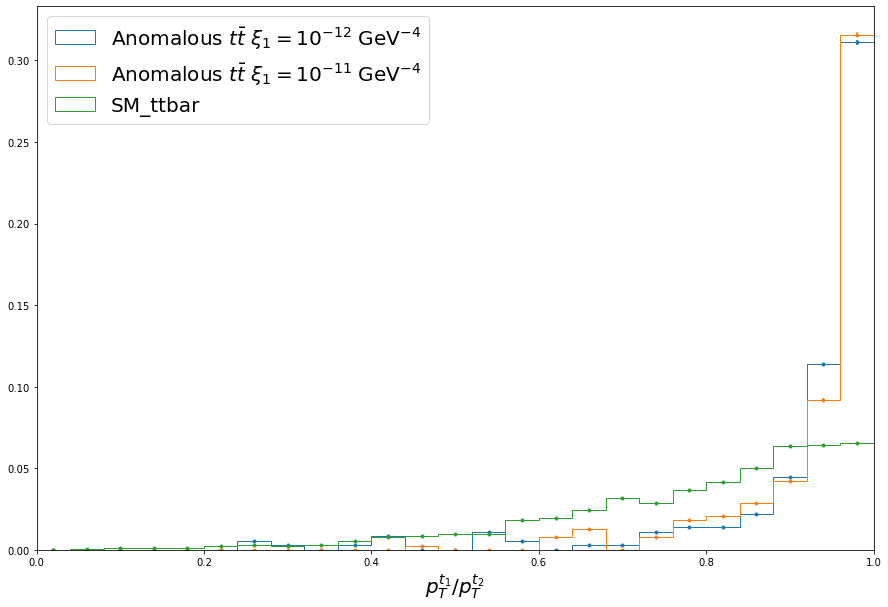

In [19]:
ax = plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(exampleSignal_1E12_semilep_presel_ds["top_1"],exampleSignal_1E12_semilep_presel_ds["top_2"])],25,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(exampleSignal_1E11_semilep_presel_ds["top_1"],exampleSignal_1E11_semilep_presel_ds["top_2"])],25,0,1,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([ (t1.pt/t2.pt) for t1,t2 in zip(SM_ttbar_semilep_presel_ds["top_1"],SM_ttbar_semilep_presel_ds["top_2"])],25,0,1,r"$p_T^{t_1}/p_T^{t_2}$","SM_ttbar",ax,normalize=True)

Maximum signal over square root of background: 6.882962473658643 for cut value: 0.8900000000000003 (sig. eff.: 89.16666666666667 %, bg. rej. 32.11610486891385 %)
Closest point to 90% signal efficiency at cut value: 0.8750000000000003 (sig. eff.: 90.27777777777779 %, bg. rej. 29.962546816479396 %)


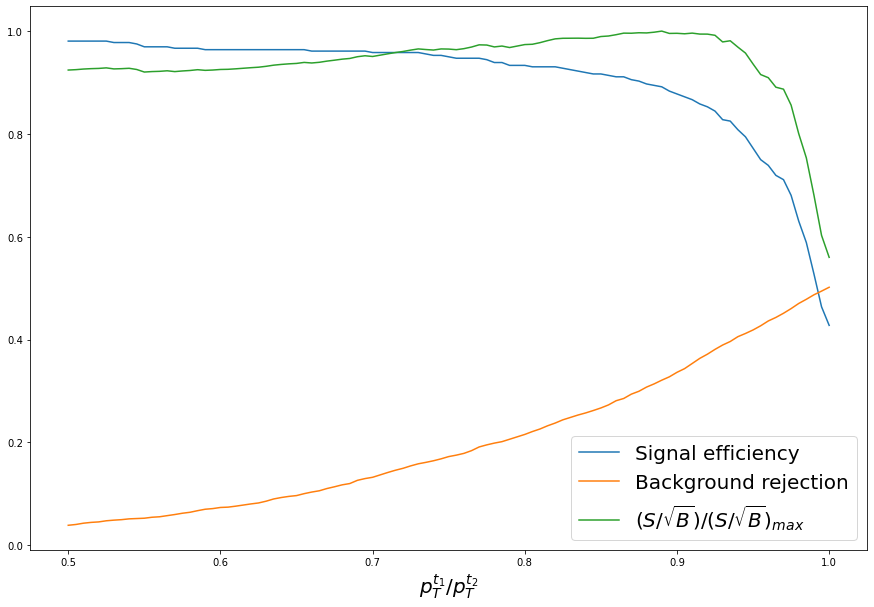

In [20]:
def topPTbalance_higherThan(ds,par):
    return [(t1.pt/t2.pt) > par for t1,t2 in zip(ds["top_1"],ds["top_2"])]

scanCut(exampleSignal_1E12_semilep_presel_ds,SM_ttbar_semilep_presel_ds,topPTbalance_higherThan,[0.5,1,0.5/100],r"$p_T^{t_1}/p_T^{t_2}$")

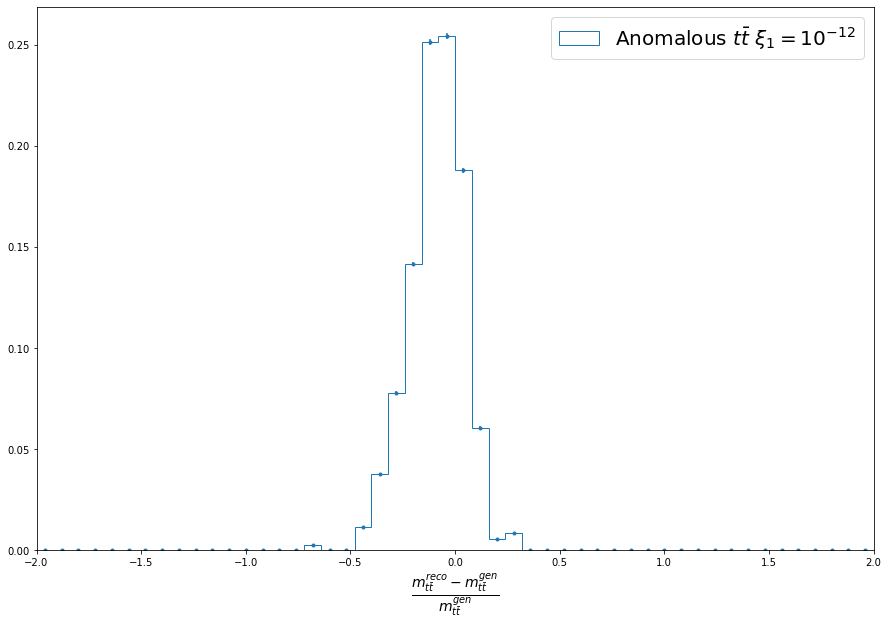

In [21]:
ax = plotWithRange((exampleSignal_1E12_semilep_presel_ds["m_ttbar"]-exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"])/exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"],50,-2,2,r"$\frac{m_{t\bar{t}}^{reco} - m_{t\bar{t}}^{gen}}{m_{t\bar{t}}^{gen}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$",scalefactor=exampleSignal_1E12_sf)
#plotWithRange(exampleSignal_1E12_semilep_presel_ds["gen_m_ttbar"],50,0,2000,r"$m_{t\bar{t}}$ [GeV]","Generated mass",ax)

<AxesSubplot:xlabel='$m_{t\\bar{t}}$ [GeV]'>

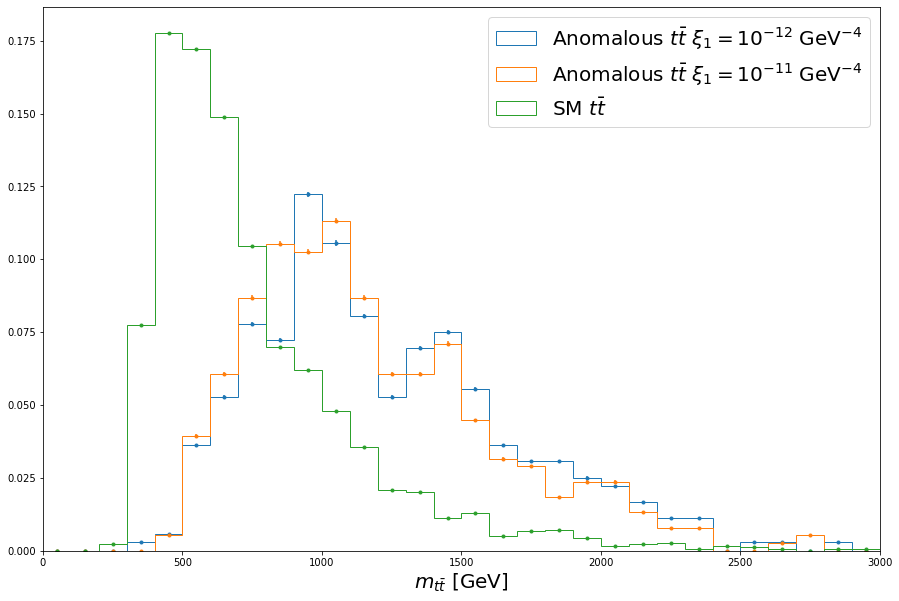

In [22]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange(exampleSignal_1E11_semilep_presel_ds["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(SM_ttbar_semilep_presel_ds["m_ttbar"],30,0,3000,r"$m_{t\bar{t}}$ [GeV]",r"SM $t\bar{t}$",ax,normalize=True)

Maximum signal over square root of background: 9.798235933493972 for cut value: 920 (sig. eff.: 73.88888888888889 %, bg. rej. 76.99750312109863 %)
Closest point to 90% signal efficiency at cut value: 700 (sig. eff.: 90.27777777777779 %, bg. rej. 57.83395755305868 %)


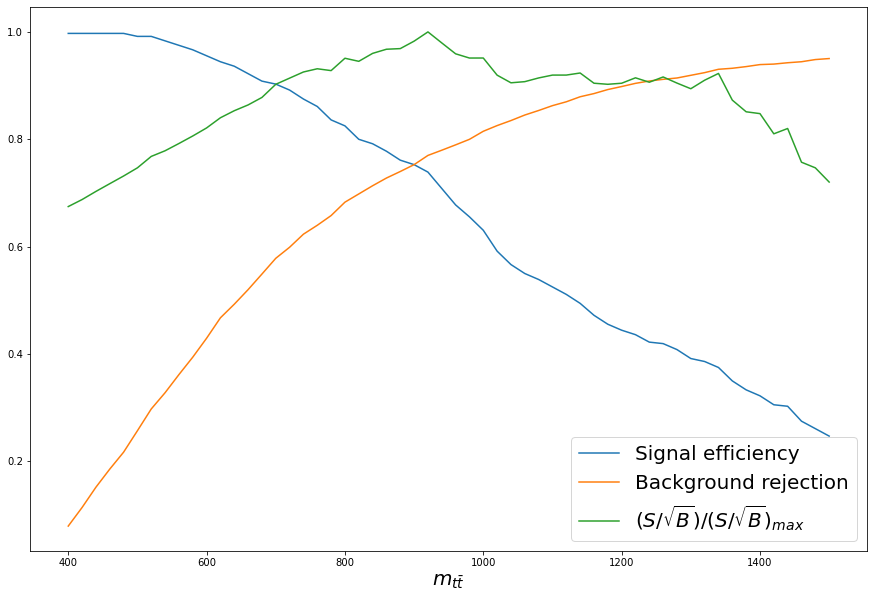

In [23]:
def mtt_greaterThan(ds,par):
    return ds["m_ttbar"] > par

scanCut(exampleSignal_1E12_semilep_presel_ds,SM_ttbar_semilep_presel_ds,mtt_greaterThan,[400,1500,20],r"$m_{t\bar{t}}$")

<AxesSubplot:xlabel='$p_T^{t_1}$ [GeV]'>

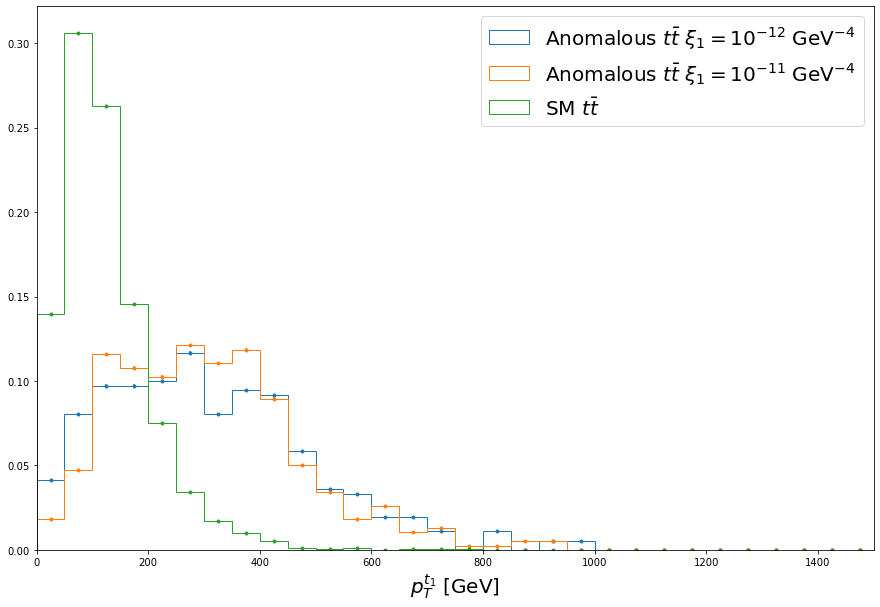

In [24]:
ax = plotWithRange([t.pt for t in exampleSignal_1E12_semilep_presel_ds["top_1"]],30,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange([t.pt for t in exampleSignal_1E11_semilep_presel_ds["top_1"]],30,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([t.pt for t in SM_ttbar_semilep_presel_ds["top_1"]],30,0,1500,r"$p_T^{t_1}$ [GeV]",r"SM $t\bar{t}$",ax,normalize=True)

Maximum signal over square root of background: 20.348218595248085 for cut value: 420 (sig. eff.: 25.27777777777778 %, bg. rej. 99.37578027465668 %)
Closest point to 90% signal efficiency at cut value: 80 (sig. eff.: 91.66666666666666 %, bg. rej. 32.05368289637952 %)


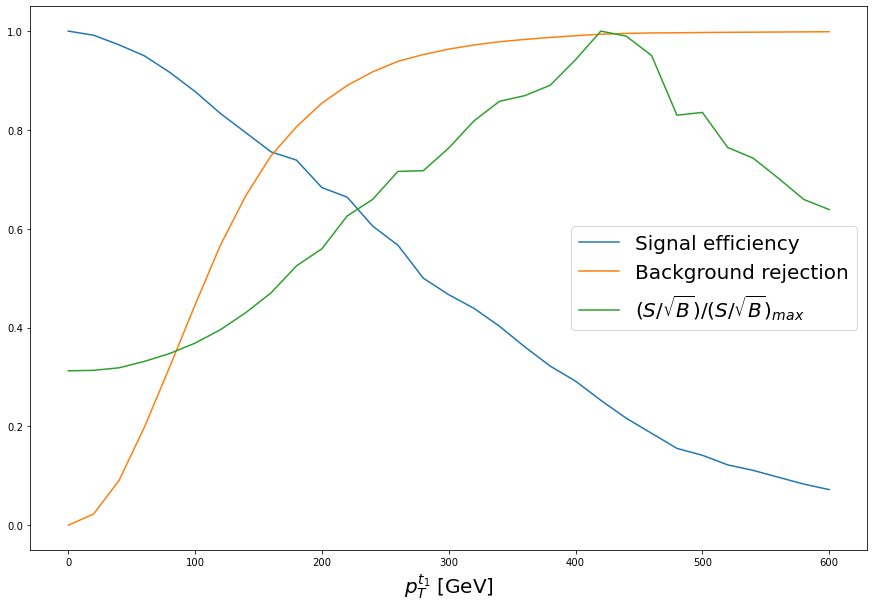

In [26]:
def top1pt_greaterThan(ds,par):
    return [t.pt > par for t in ds["top_1"]] 

scanCut(exampleSignal_1E12_semilep_presel_ds,SM_ttbar_semilep_presel_ds,top1pt_greaterThan,[0,600,20],r"$p_T^{t_1}$ [GeV]")

<AxesSubplot:xlabel='$p_T^{t_2}$ [GeV]'>

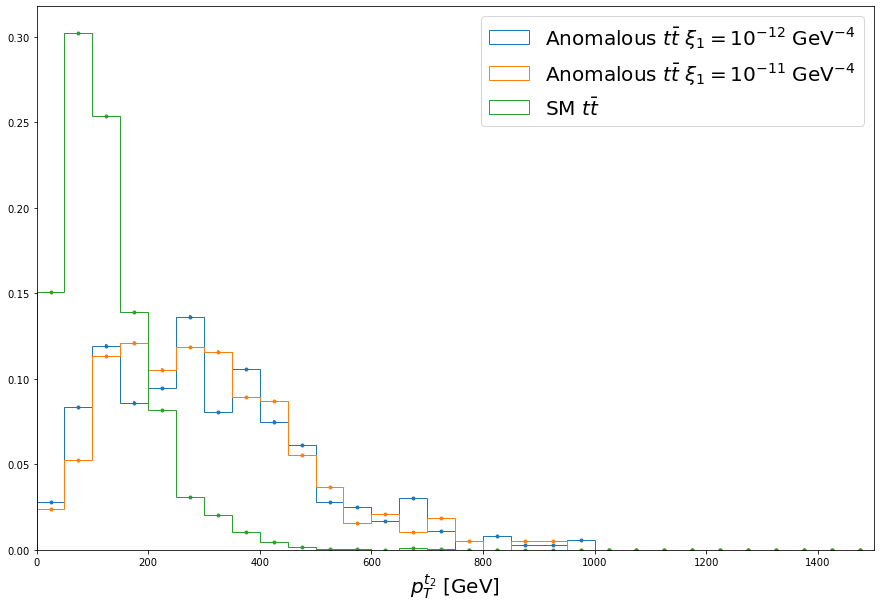

In [27]:
ax = plotWithRange([t.pt for t in exampleSignal_1E12_semilep_presel_ds["top_2"]],30,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange([t.pt for t in exampleSignal_1E11_semilep_presel_ds["top_2"]],30,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange([t.pt for t in SM_ttbar_semilep_presel_ds["top_2"]],30,0,1500,r"$p_T^{t_2}$ [GeV]",r"SM $t\bar{t}$",ax,normalize=True)

Maximum signal over square root of background: 18.76388374866284 for cut value: 460 (sig. eff.: 18.055555555555554 %, bg. rej. 99.625468164794 %)
Closest point to 90% signal efficiency at cut value: 100 (sig. eff.: 88.88888888888889 %, bg. rej. 45.349563046192266 %)


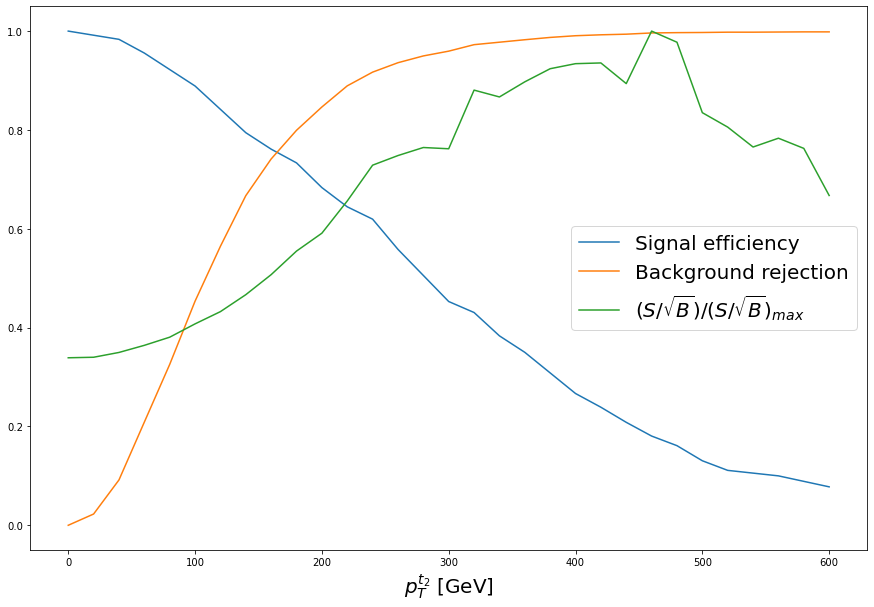

In [28]:
def top2pt_greaterThan(ds,par):
    return [t.pt > par for t in ds["top_2"]] 

scanCut(exampleSignal_1E12_semilep_presel_ds,SM_ttbar_semilep_presel_ds,top2pt_greaterThan,[0,600,20],r"$p_T^{t_2}$ [GeV]")

Maximum signal over square root of background: 12.038637106532837 for cut value: 480 (sig. eff.: 61.38888888888889 %, bg. rej. 89.48189762796504 %)
Closest point to 90% signal efficiency at cut value: 320 (sig. eff.: 87.5 %, bg. rej. 60.86142322097379 %)


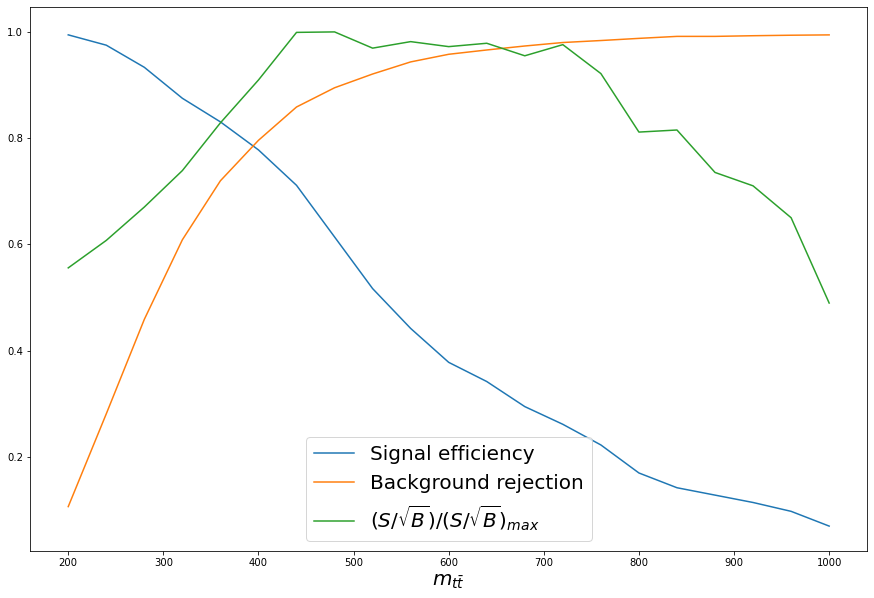

In [29]:
def HT_greaterThan(ds,par):
    return ds["Jet_pt_tot"]+ds["BJet_pt_tot"] > par

scanCut(exampleSignal_1E12_semilep_presel_ds,SM_ttbar_semilep_presel_ds,HT_greaterThan,[200,1000,40],r"$m_{t\bar{t}}$")

<AxesSubplot:xlabel='$H_T$'>

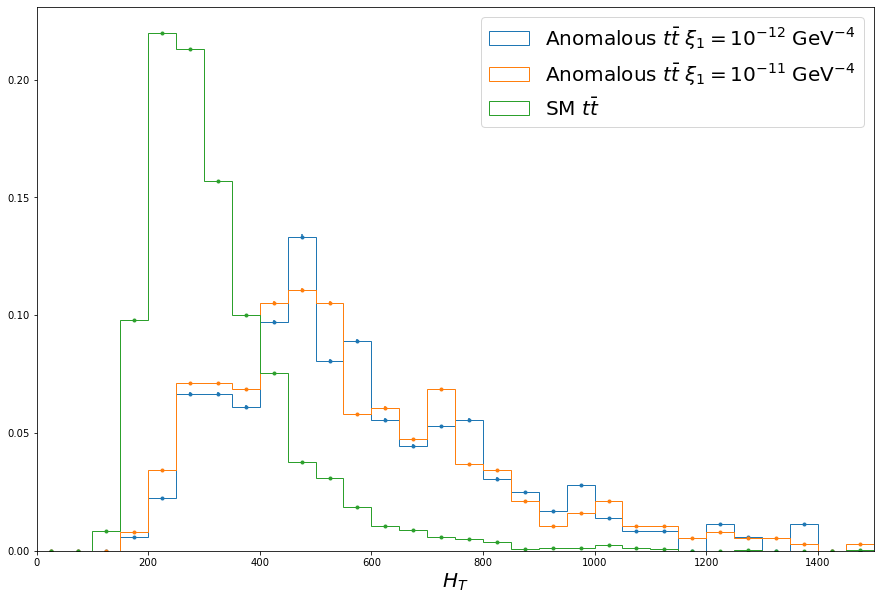

In [30]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E12_semilep_presel_ds["BJet_pt_tot"],30,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E11_semilep_presel_ds["BJet_pt_tot"],30,0,1500,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_pt_tot"]+SM_ttbar_semilep_presel_ds["BJet_pt_tot"],30,0,1500,r"$H_T$",r"SM $t\bar{t}$",ax,normalize=True)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["Jet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["Jet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["Jet_1"]],50,-5,5,r"$\eta_{j1}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["Jet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["Jet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["Jet_2"]],50,-5,5,r"$\eta_{j2}$","SM $t\bar{t}$",ax)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["BJet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["BJet_1"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["BJet_1"]],50,-5,5,r"$\eta_{Bj1}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange([j.eta for j in exampleSignal_1E12_semilep_presel_ds["BJet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([j.eta for j in exampleSignal_1E11_semilep_presel_ds["BJet_2"]],50,-5,5,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange([j.eta for j in SM_ttbar_semilep_presel_ds["BJet_2"]],50,-5,5,r"$\eta_{Bj2}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["m_ttbar"]-exampleSignal_1E12_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["m_ttbar"]-exampleSignal_1E11_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["m_ttbar"]-SM_ttbar_semilep_presel_ds["m_protons"],50,-1000,1000,r"$\Delta m_{t\bar{t}}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["y_ttbar"]-exampleSignal_1E12_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["y_ttbar"]-exampleSignal_1E11_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["y_ttbar"]-SM_ttbar_semilep_presel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange([i[0] for i in exampleSignal_1E12_semilep_presel_ds["Jet.PT"]],50,0,2000,r"$m_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange([i[0] for i in SM_ttbar_semilep_presel_ds["Jet.PT"]],50,0,2000,r"$p_{T}^{jet}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["BJet_energy_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["BJet_energy_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["BJet_energy_tot"],30,0,1000,r"$E_{BJets}^{tot}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_energy_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_energy_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_energy_tot"],30,0,1000,r"$E^{tot}_{Jets}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["BJet_pt_tot"],30,0,1000,r"BJets $P_{T}^{tot}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E12")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_pt_tot"],30,0,1000,"","Anomalous_ttbar_1E11",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_pt_tot"],30,0,1000,r"Jets $P_T^{tot}$","SM_ttbar",ax)

In [ ]:
ax = plotWithRange(exampleSignal_1E12_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E12_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$")
plotWithRange(exampleSignal_1E11_semilep_presel_ds["Jet_pt_tot"]+exampleSignal_1E11_semilep_presel_ds["BJet_pt_tot"],30,0,1000,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax)
plotWithRange(SM_ttbar_semilep_presel_ds["Jet_pt_tot"]+SM_ttbar_semilep_presel_ds["BJet_pt_tot"],30,0,1000,r"$H_T$","SM_ttbar",ax)

In [33]:
def semilepAnalysisCentralSelection(dataset):   
    
    ht_sel = HT_greaterThan(dataset,480)    # GeV
    m_tt_sel = mtt_greaterThan(dataset,920) # GeV
    acop_sel = acoplanarity_lowerThan(dataset,0.09)
    ptbalance_sel = topPTbalance_higherThan(dataset,0.9)
    topPt1_sel = top1pt_greaterThan(dataset,150)
    topPt2_sel = top2pt_greaterThan(dataset,150)
    semilep_central_sel = ht_sel & m_tt_sel & acop_sel & ptbalance_sel & topPt1_sel & topPt2_sel
    frac_passing = 1.*np.count_nonzero(semilep_central_sel)/len(dataset["Jet.PT"])
    print("Passing central selection:", np.count_nonzero(semilep_central_sel),"({:.2f}%)".format(100.*frac_passing))    

    for key in dataset:
        dataset[key] = dataset[key][semilep_central_sel]
        
    return dataset,frac_passing

In [34]:
# perform central selection
exampleSignal_1E12_semilep_centralsel_ds,frac_passing_semilep_centralsel_signal_1E12 = semilepAnalysisCentralSelection(exampleSignal_1E12_semilep_presel_ds)
exampleSignal_1E11_semilep_centralsel_ds,frac_passing_semilep_centralsel_signal_1E11 = semilepAnalysisCentralSelection(exampleSignal_1E11_semilep_presel_ds)
SM_ttbar_semilep_centralsel_ds,frac_passing_semilep_centralsel_SM_ttbar = semilepAnalysisCentralSelection(SM_ttbar_semilep_presel_ds)

Passing central selection: 149 (41.39%)
Passing central selection: 153 (40.26%)
Passing central selection: 110 (3.43%)


<AxesSubplot:xlabel='$1 - \\frac{m_{t\\bar{t}}^{central}}{m_{t\\bar{t}}^{protons}}$'>

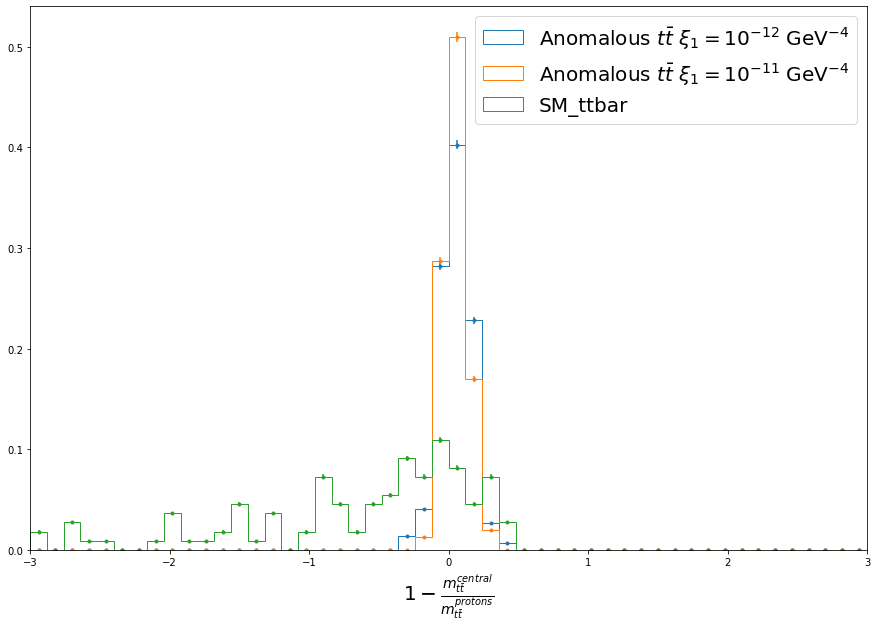

In [41]:
ax = plotWithRange(1 - exampleSignal_1E12_semilep_centralsel_ds["m_ttbar"]/exampleSignal_1E12_semilep_centralsel_ds["m_protons"],50,-3,3,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange(1 - exampleSignal_1E11_semilep_centralsel_ds["m_ttbar"]/exampleSignal_1E11_semilep_centralsel_ds["m_protons"],50,-3,3,"",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-11}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(1 - SM_ttbar_semilep_centralsel_ds["m_ttbar"]/SM_ttbar_semilep_centralsel_ds["m_protons"],50,-3,3,r"$1 - \frac{m_{t\bar{t}}^{central}}{m_{t\bar{t}}^{protons}}$","SM_ttbar",ax,normalize=True)

In [ ]:
# def absmassmatch_lowerThan(ds,par):
    return np.abs(1 - ds["m_ttbar"]/ds["m_protons"]) < par

scanCut(exampleSignal_1E12_semilep_centralsel_ds,SM_ttbar_semilep_centralsel_ds,absmassmatch_lowerThan,[0,1,1/50],r"$1 - \frac{m_{t\bar{t}}^{central}}{m_{t\bar{t}}^{protons}}$")

<AxesSubplot:xlabel='$\\Delta y_{t\\bar{t}}$'>

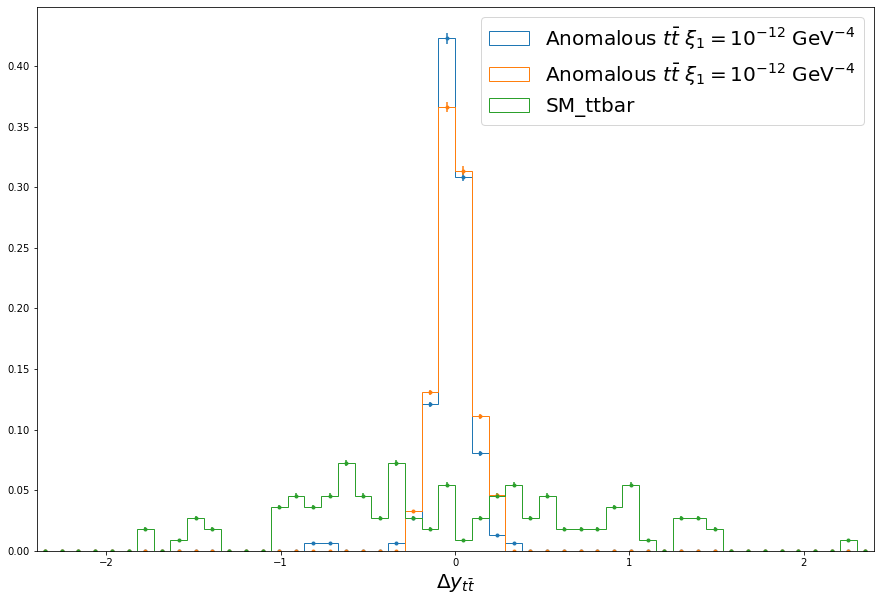

In [43]:
ax = plotWithRange(exampleSignal_1E12_semilep_centralsel_ds["y_ttbar"]-exampleSignal_1E12_semilep_centralsel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",normalize=True)
plotWithRange(exampleSignal_1E11_semilep_centralsel_ds["y_ttbar"]-exampleSignal_1E11_semilep_centralsel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$",r"Anomalous $t\bar{t}$ $\xi_1 = 10^{-12}$ GeV$^{-4}$",ax,normalize=True)
plotWithRange(SM_ttbar_semilep_centralsel_ds["y_ttbar"]-SM_ttbar_semilep_centralsel_ds["y_protons"],50,-2.4,2.4,r"$\Delta y_{t\bar{t}}$","SM_ttbar",ax,normalize=True)

No BG events passed for par =  0.0 
Using 0.0001 as symbolic value
Maximum signal over square root of background: 41.198127558005766 for cut value: 0.1 (sig. eff.: 73.15436241610739 %, bg. rej. 93.63636363636364 %)
Closest point to 90% signal efficiency at cut value: 0.15000000000000002 (sig. eff.: 87.24832214765101 %, bg. rej. 90.9090909090909 %)


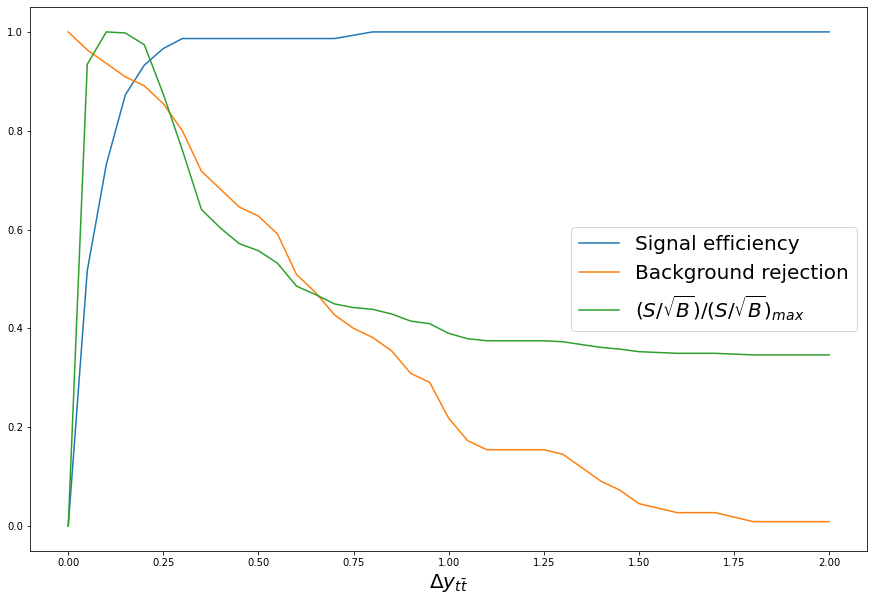

In [45]:
def absdeltarapidity_lowerThan(ds,par):
    return np.abs(ds["y_ttbar"]-ds["y_protons"]) < par

scanCut(exampleSignal_1E12_semilep_centralsel_ds,SM_ttbar_semilep_centralsel_ds,absdeltarapidity_lowerThan,[0,2,0.05],r"$\Delta y_{t\bar{t}}$")

In [46]:
def semilepAnalysisProtonSelection(dataset):     
    mass_match_sel = absmassmatch_lowerThan(dataset,0.16) #GeV
    rapidity_match_sel = absdeltarapidity_lowerThan(dataset,0.15) #GeV
    semilep_proton_sel = mass_match_sel & rapidity_match_sel
    frac_passing = 1.*np.count_nonzero(semilep_proton_sel)/len(dataset["Jet.PT"])
    print("Passing proton selection:", np.count_nonzero(semilep_proton_sel),"({:.2f}%)".format(100.*frac_passing))    

    for key in dataset:
        dataset[key] = dataset[key][semilep_proton_sel]
        
    return dataset,frac_passing

In [47]:
exampleSignal_1E12_semilep_fullsel_ds,frac_passing_semilep_fullsel_signal_1E12 = semilepAnalysisProtonSelection(exampleSignal_1E12_semilep_centralsel_ds)
exampleSignal_1E11_semilep_fullsel_ds,frac_passing_semilep_fullsel_signal_1E11 = semilepAnalysisProtonSelection(exampleSignal_1E11_semilep_centralsel_ds)
SM_ttbar_semilep_fullsel_ds,frac_passing_semilep_fullsel_SM_ttbar = semilepAnalysisProtonSelection(SM_ttbar_semilep_centralsel_ds)

Passing proton selection: 115 (77.18%)
Passing proton selection: 122 (79.74%)
Passing proton selection: 3 (2.73%)


In [48]:
print(r"Events expected for",lumi_tot,"1/fb$:")
print("Xi1=1E12:",len(exampleSignal_1E12_semilep_fullsel_ds["Jet.PT"]) * exampleSignal_1E12_sf)
print("Xi1=1E11:",len(exampleSignal_1E11_semilep_fullsel_ds["Jet.PT"]) * exampleSignal_1E11_sf)
print("SM_ttbar:",len(SM_ttbar_semilep_fullsel_ds["Jet.PT"]) * SM_ttbar_sf)

Events expected for 300.0 1/fb$:
Xi1=1E12: 0.3326156928728791
Xi1=1E11: 35.28618654825134
SM_ttbar: 4237.90848


In [49]:
# final table
passing_signal_1E12 = 1
passing_signal_1E11 = 1
passing_background_SM_ttbar = 1 

print("","Xi1 = 1E12","Xi1 = 1E11","SM ttbar")

passing_signal_1E12 *= frac_passing_semilep_presel_signal_1E12
passing_signal_1E11 *= frac_passing_semilep_presel_signal_1E11
passing_background_SM_ttbar *= protons_in_pps_weight*frac_passing_semilep_presel_SM_ttbar
print("Passing pre-selection:\t",passing_signal_1E12,passing_signal_1E11,passing_background_SM_ttbar,sep="\t")

passing_signal_1E12 *= frac_passing_semilep_centralsel_signal_1E12
passing_signal_1E11 *= frac_passing_semilep_centralsel_signal_1E11
passing_background_SM_ttbar *= frac_passing_semilep_centralsel_SM_ttbar
print("Passing central selection:",passing_signal_1E12,passing_signal_1E11,passing_background_SM_ttbar,sep="\t")

passing_signal_1E12 *= frac_passing_semilep_fullsel_signal_1E12
passing_signal_1E11 *= frac_passing_semilep_fullsel_signal_1E11
passing_background_SM_ttbar *= frac_passing_semilep_fullsel_SM_ttbar
print("Passing proton selection:",passing_signal_1E12,passing_signal_1E11,passing_background_SM_ttbar,sep="\t")

 Xi1 = 1E12 Xi1 = 1E11 SM ttbar
Passing pre-selection:		0.03663003663003663	0.03866503866503866	0.0181333584
Passing central selection:	0.015160765160765161	0.015567765567765566	0.000622556
Passing proton selection:	0.0117012617012617	0.012413512413512413	1.69788e-05
